##### %pylab inline
%precision 6

In [2]:
%load_ext autoreload
%autoreload 1
%aimport common

In [3]:
import pandas as pd
import sklearn as skl
import sklearn

In [4]:
from common.serialization import pickle_load, pickle_save
from common.classes.Struct import Struct
from common.feature_transformations import get_one_hot_encoding
from common.functions import all_nums
from common.visualize.colors import COLORS
from common.visualize.distributions import *

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [6]:
from tqdm import tqdm
import datetime

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
pd.options.display.max_colwidth=100
np.set_printoptions(linewidth=140,edgeitems=10)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
rcParams['figure.figsize'] = (8.0, 5.0)

In [9]:
Z_train = pd.read_csv('Data/train.csv', skipinitialspace=True, sep=',', encoding='latin', index_col='Id')
Z_test = pd.read_csv('Data/test.csv', skipinitialspace=True, sep=',', encoding='latin', index_col='Id')

In [10]:
Z_train.head()

,Hotel_name,Review_Title,Review_Text,Rating
Id,,,,
0,Park Hyatt,Refuge in Chennai,Excellent room and exercise facility. All around atmosphere was calm and comfortable. Main dinin...,80.0
1,Hilton Chennai,Hilton Chennai,Very comfortable and felt safe. \nStaff were very helpful and respectful. Breakfast offered a wi...,100.0
2,The Royal Regency,No worth the rating shown in websites. Pricing is OK,Not worth the rating shown. Service is not good. Room not well maintained. Room are spacious. Il...,71.0
3,Rivera,Good stay,"First of all nice & courteous staff, only one con during my stay was at time of check in at nigh...",86.0
4,Park Hyatt,Needs improvement,Overall ambience of the hotel is very good. In room facilities need to improve & there is a need...,86.0


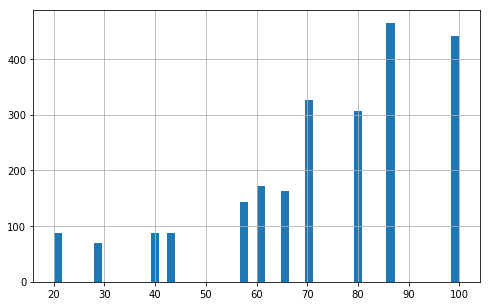

In [11]:
Z_train.Rating.hist(bins=50)

In [12]:
train_inds = Z_train.index.values
test_inds = Z_test.index.values

In [13]:
Z=pd.concat([Z_train,Z_test])

In [14]:
train_inds, test_inds

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9, ..., 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350], dtype=int64),
 array([2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, ..., 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702], dtype=int64))

In [15]:
del Z_train, Z_test

In [16]:
len(Z), len(train_inds)+len(test_inds)

(4703, 4703)

In [17]:
Z.columns

Index(['Hotel_name', 'Rating', 'Review_Text', 'Review_Title'], dtype='object')

In [18]:
Z.dtypes

Hotel_name       object
Rating          float64
Review_Text      object
Review_Title     object
dtype: object

In [19]:
Z.rename(columns={'Review_Text':'Text','Review_Title':'Title', 'Hotel_name':'Hotel'}, inplace=True)

In [20]:
Z.Title = Z.Title.fillna('')
Z.Text = Z.Text.fillna('')

# Train set, testing set

In [21]:
from sklearn import linear_model

In [22]:
Z['Combined'] = Z['Title']+' | '+Z['Text']+' | '+Z['Hotel']

In [23]:
X_train = Z.loc[train_inds,'Combined'].values
Y_train = Z.loc[train_inds,'Rating'].values

X_test = Z.loc[test_inds,'Combined'].values
Y_test = Z.loc[test_inds,'Rating'].values

In [24]:
text_model = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('model', linear_model.Ridge(max_iter = 50000)),
])

#### Master solution: 13.702971

#### Best score: 13.2811117101, {'model__alpha': 0.10473222288188955, 'vect__ngram_range': (1, 4)}, None

In [ ]:
%%time

special_list = []
header = str(datetime.datetime.now()).center(120, '=') + '\n'
with open('Logs/hotel.log', 'a') as f:
    f.write(header)

tolerance = [10**(-a) for a in range(10)]
    
for to in tqdm(tolerance): # linear_model.Ridge
    for nor in tqdm(['l1', 'l2', None]): # TfidfTransformer
        text_model = Pipeline([('vect', CountVectorizer(stop_words='english')),
                             ('tfidf', TfidfTransformer(norm=nor)),
                             ('model', linear_model.Ridge(random_state=0, tol=to, max_iter=10000)), # alpha is define in parameters above 
        ])

        model = GridSearchCV(text_model, parameters, scoring='neg_mean_squared_error', n_jobs=-1)

        model = gs_model.fit(X_train, Y_train)

        special_list.append((model.best_score_, model.best_params_))

        # Just interesting results
        if sqrt(-model.best_score_) < 14: 
            with open('Logs/hotel.log', 'a') as f:
                f.write('Score:\t' + str(model.best_score_) + '\tParams:\t' + \
                        str(model.best_params_) + '\tNorm:\t' + str(nor) + '\n')

  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
print(model.best_score_, model.best_params_)
print(sqrt(-model.best_score_))

-176.387928257 {'model__alpha': 0.10473222288188955, 'vect__ngram_range': (1, 4)}
13.2811117101


# Visualization 

In [62]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=3, random_state=0)

In [63]:
tsvd.fit(X_train)
X_tsvd = tsvd.transform(X_train)

In [64]:
X_tsvd.shape

(2351, 3)

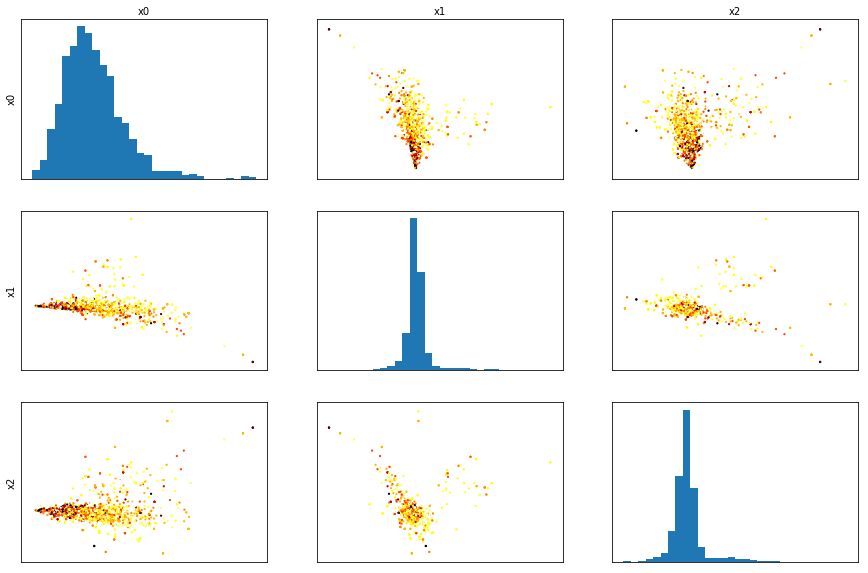

In [77]:
cross_distributions_regression(X_tsvd, Y_train, figsize=(15,10))

In [71]:
with open('Logs/top_5.log', 'w') as f:
    f.write(str(sorted(special_list, key = lambda x: x[0], reverse=True)[:5]))

# Submission

In [26]:
Z.loc[test_inds].index

Int64Index([2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360,
            ...
            4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702], dtype='int64', name='Id', length=2352)

In [27]:
Y_hat = gs_model.predict(X_test)

In [28]:
S = pd.DataFrame(Y_hat, columns=['Rating'], index = Z.loc[test_inds].index) 

In [29]:
S.head()

,Rating
Id,
2351,97.200559
2352,69.680822
2353,76.819393
2354,31.313600
2355,87.523022


In [30]:
S.to_csv('Data/baseline_solution.csv', index=True)

Try out the following ideas:
    * give different weight to the words in the title
    * treat words in the title as separate features
    * as values of Rating belong to a small subset, how about using classification?
    * try non-linear models
    * is the presence of ?!,. important? Does their distribution have outliers? Is it better truncating their number?
    * generate new features - number of words, lines, etc.
    * how about stacking/blending different models?
    * what parts-of speech are the most important? Probably adjectives?
    * treat negation (not good, not excellent, etc)
    * treat negation separated by other words (not at all good, etc.)
    * treat very good, extremely good, highly appreciate, etc.
    * are adjectives and adverbs more important? try treating them differently. 
        * you can find them using NLTK python package (part-of-speech tagging).
    * try using separate datasets with words polarity. Construct new features with that.
        * see https://www.quora.com/Is-there-a-downloadable-database-of-positive-and-negative-words